CIFAR-100
=====

CIFAR-100 데이터를 이용한 Image classification 연습
---------------------------------------------

---

<center>
<h2>[Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842)</h2>   

Christian Szegedy  
Google Inc.  
Wei Liu  
University of North Carolina, Chapel Hill  
Yangqing Jia  
Google Inc.  
Pierre Sermanet  
Google Inc.  
Scott Reed  
University of Michigan  
Dragomir Anguelov  
Google Inc.  
Dumitru Erhan  
Google Inc.  
Vincent Vanhoucke  
Google Inc.  
Andrew Rabinovich  
Google Inc.   


   

arXiv:1409.4842v1 [cs.CV] 17 Sep 2014  
</center>

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import prettytensor as pt
from sklearn.metrics import confusion_matrix
import numpy as np
import time
from datetime import datetime
from datetime import timedelta
import math
import os
import cifar100

In [2]:
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib.framework.python.ops import arg_scope
from tensorflow.contrib.layers.python.layers import initializers
from tensorflow.contrib.layers.python.layers import layers as layers_lib
from tensorflow.contrib.layers.python.layers import regularizers
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import variable_scope

trunc_normal = lambda stddev: init_ops.truncated_normal_initializer(0.0, stddev)

## 데이터 불러오기

In [3]:
cifar100.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


cifar100 데이터는 32X32 크기의 사진 6만장이 들어있다.  
그 중 5만장은 Test set, 1만장은 Test set 으로 구성되어 있다.  
이미지의 class 는 100개이고 각 class 마다 균등하게 배분되어 있다.

사실 CIFAR100은 상위 클레스가 존재하는 데 20개로 구성되어 있고, 하위로 각 5개씩 존재해서 100개인 것이다.  
상위 클레스로 20개만 사용하고 싶으면 cifa100.py에  다음과 같이 대체하자. 
* label에 "coarse_labels"
* meta에 "coarse_label_names"

In [4]:
class_names = cifar100.load_class_names()
class_names[:10]

Loading data: data/CIFAR-100/cifar-100-python/meta


['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle']

각 data set을 로드한다. Training set은 용량 문제로 5개의 배치파일로 분리되어 있다.

In [5]:
images_train, cls_train, labels_train = cifar100.load_training_data()

Loading data: data/CIFAR-100/cifar-100-python/train


Load the test-set.

In [6]:
images_test, cls_test, labels_test = cifar100.load_test_data()

Loading data: data/CIFAR-100/cifar-100-python/test


In [7]:
print("Size of:")
print("- Training-set:\t{}".format(len(images_train)))
print("- Test-set:\t{}".format(len(images_test)))

Size of:
- Training-set:	50000
- Test-set:	10000


### Data Dimensions

In [8]:
from cifar100 import img_size, num_channels, num_classes

In [9]:
img_size_padding = 40
img_size_cropped = 32

### 데이터가 올바른지 확인하기 위해 몇가지 이미지를 확인한다.

3x3 그리드에 9개의 이미지를 그리는 데 사용되는 함수이며, 각 이미지 아래의 실제 및 예상 class를 보여준다.

In [10]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    fig, axes = plt.subplots(3, 3)

    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
        
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):

        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        ax.imshow(images[i, :, :, :], interpolation=interpolation)
            
        cls_true_name = class_names[cls_true[i]]

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8, forward=True)    
    plt.show()

다음 사진은 test set의 처음 9개의 사진이다.

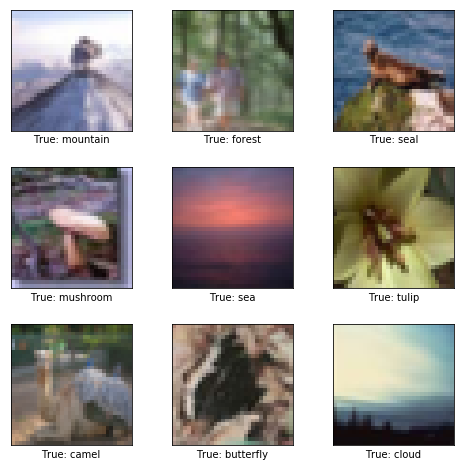

In [11]:
images = images_test[0:9]
cls_true = cls_test[0:9]

plot_images(images=images, cls_true=cls_true, smooth=False)

plt 패키지의 spline16를 이용해서 사진을 부드럽게 만들 수 있다.

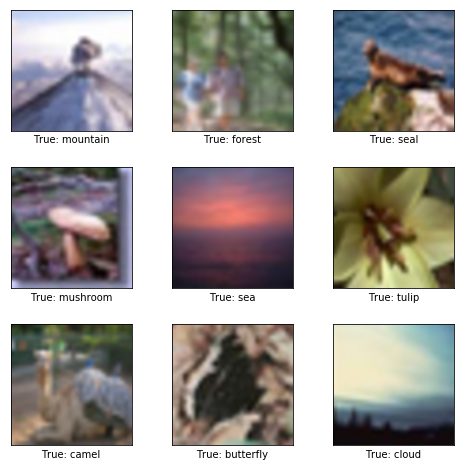

In [12]:
plot_images(images=images, cls_true=cls_true, smooth=True)

## TensorFlow Graph

### Placeholder variables

In [13]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_cls = tf.argmax(y_true, 1)

### 이미지 전처리 작업

In [14]:
def pre_process_image(image, training):
    
    if training:

        # 랜덤하게 좌우 반전 한다.
        image = tf.image.random_flip_left_right(image)
        
        # 랜덤하게 색상, 대비, 밝기, 채도를 조정한다.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

        # 너무 심하게 바뀐 경우를 대비해 1과 0 사이값으로 맞춘다.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0)
        
        # DeepNiN 이미지 확장용 Padding
        image = tf.image.resize_image_with_crop_or_pad(
            image, target_height=img_size_padding, target_width=img_size_padding)
        
        # 랜덤하게 부분적으로 잘라낸다.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        
    else:
        # 테스트시 중앙을 기준으로 이미지를 32x32으로 자른다.
        image = tf.image.resize_image_with_crop_or_pad(
            image, target_height=img_size_cropped, target_width=img_size_cropped)

    return image

In [15]:
def pre_process(images, training):
    
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    
    return images

In [16]:
distorted_images = pre_process(images=x, training=True)
distorted_images

<tf.Tensor 'map/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, 32, 32, 3) dtype=float32>

### [Rethinking the Inception Architecture for Computer Vision - paper](https://arxiv.org/abs/1512.00567)

#### Inception -V3

In [ ]:
from IPython.display import Image
Image('images/inception-v3.png')

#### 이미지 사이즈 문제로 초기 (Conv) x 3 - MP 제거.

In [17]:
def inception_v3_base(inputs,
                      final_endpoint='Mixed_7c',
                      min_depth=8,
                      depth_multiplier=1.0,
                      scope=None):

    end_points = {}

    depth = lambda d: max(int(d * depth_multiplier), min_depth)

    with variable_scope.variable_scope(scope, 'InceptionV3', [inputs]):
        with arg_scope(
                [layers.conv2d, layers_lib.max_pool2d, layers_lib.avg_pool2d],
                stride=1,
                padding='VALID'):
            
#             # 299 x 299 x 3
#             end_point = 'Conv2d_1a_3x3'
#             net = layers.conv2d(inputs, depth(32), [3, 3], stride=2, scope=end_point)
#             end_points[end_point] = net
#             if end_point == final_endpoint:
#                 return net, end_points
#             # 149 x 149 x 32
#             end_point = 'Conv2d_2a_3x3'
#             net = layers.conv2d(net, depth(32), [3, 3], scope=end_point)
#             end_points[end_point] = net
#             if end_point == final_endpoint:
#                 return net, end_points
#             # 147 x 147 x 32
#             end_point = 'Conv2d_2b_3x3'
#             net = layers.conv2d(
#                 net, depth(64), [3, 3], padding='SAME', scope=end_point)
#             end_points[end_point] = net
#             if end_point == final_endpoint:
#                 return net, end_points
#             # 147 x 147 x 64
#             end_point = 'MaxPool_3a_3x3'
#             net = layers_lib.max_pool2d(net, [3, 3], stride=2, scope=end_point)
#             end_points[end_point] = net
#             if end_point == final_endpoint:
#                 return net, end_points
            # 73 x 73 x 64
            end_point = 'Conv2d_3b_1x1'
            net = layers.conv2d(inputs, depth(80), [1, 1], scope=end_point)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points
            # 73 x 73 x 80.
            end_point = 'Conv2d_4a_3x3'
            net = layers.conv2d(net, depth(192), [3, 3], scope=end_point)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points
            # 71 x 71 x 192.
            end_point = 'MaxPool_5a_3x3'
            net = layers_lib.max_pool2d(net, [3, 3], stride=1, scope=end_point)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points
                # 35 x 35 x 192.

                # Inception blocks
        with arg_scope(
                [layers.conv2d, layers_lib.max_pool2d, layers_lib.avg_pool2d],
                stride=1,
                padding='SAME'):
            # mixed: 35 x 35 x 256.
            end_point = 'Mixed_5b'
            with variable_scope.variable_scope(end_point):
                with variable_scope.variable_scope('Branch_0'):
                    branch_0 = layers.conv2d(
                        net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
                with variable_scope.variable_scope('Branch_1'):
                    branch_1 = layers.conv2d(
                        net, depth(48), [1, 1], scope='Conv2d_0a_1x1')
                    branch_1 = layers.conv2d(
                        branch_1, depth(64), [5, 5], scope='Conv2d_0b_5x5')
                with variable_scope.variable_scope('Branch_2'):
                    branch_2 = layers.conv2d(
                        net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(96), [3, 3], scope='Conv2d_0b_3x3')
                    branch_2 = layers.conv2d(
                        branch_2, depth(96), [3, 3], scope='Conv2d_0c_3x3')
                with variable_scope.variable_scope('Branch_3'):
                    branch_3 = layers_lib.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                    branch_3 = layers.conv2d(
                        branch_3, depth(32), [1, 1], scope='Conv2d_0b_1x1')
                net = array_ops.concat([branch_0, branch_1, branch_2, branch_3], 3)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points

            # mixed_1: 35 x 35 x 288.
            end_point = 'Mixed_5c'
            with variable_scope.variable_scope(end_point):
                with variable_scope.variable_scope('Branch_0'):
                    branch_0 = layers.conv2d(
                        net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
                with variable_scope.variable_scope('Branch_1'):
                    branch_1 = layers.conv2d(
                        net, depth(48), [1, 1], scope='Conv2d_0b_1x1')
                    branch_1 = layers.conv2d(
                        branch_1, depth(64), [5, 5], scope='Conv_1_0c_5x5')
                with variable_scope.variable_scope('Branch_2'):
                    branch_2 = layers.conv2d(
                        net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(96), [3, 3], scope='Conv2d_0b_3x3')
                    branch_2 = layers.conv2d(
                        branch_2, depth(96), [3, 3], scope='Conv2d_0c_3x3')
                with variable_scope.variable_scope('Branch_3'):
                    branch_3 = layers_lib.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                    branch_3 = layers.conv2d(
                        branch_3, depth(64), [1, 1], scope='Conv2d_0b_1x1')
                net = array_ops.concat([branch_0, branch_1, branch_2, branch_3], 3)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points

            # mixed_2: 35 x 35 x 288.
            end_point = 'Mixed_5d'
            with variable_scope.variable_scope(end_point):
                with variable_scope.variable_scope('Branch_0'):
                    branch_0 = layers.conv2d(
                        net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
                with variable_scope.variable_scope('Branch_1'):
                    branch_1 = layers.conv2d(
                        net, depth(48), [1, 1], scope='Conv2d_0a_1x1')
                    branch_1 = layers.conv2d(
                        branch_1, depth(64), [5, 5], scope='Conv2d_0b_5x5')
                with variable_scope.variable_scope('Branch_2'):
                    branch_2 = layers.conv2d(
                        net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(96), [3, 3], scope='Conv2d_0b_3x3')
                    branch_2 = layers.conv2d(
                        branch_2, depth(96), [3, 3], scope='Conv2d_0c_3x3')
                with variable_scope.variable_scope('Branch_3'):
                    branch_3 = layers_lib.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                    branch_3 = layers.conv2d(
                        branch_3, depth(64), [1, 1], scope='Conv2d_0b_1x1')
                net = array_ops.concat([branch_0, branch_1, branch_2, branch_3], 3)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points

            # mixed_3: 17 x 17 x 768.
            end_point = 'Mixed_6a'
            with variable_scope.variable_scope(end_point):
                with variable_scope.variable_scope('Branch_0'):
                    branch_0 = layers.conv2d(
                        net,
                        depth(384), [3, 3],
                        stride=2,
                        padding='VALID',
                        scope='Conv2d_1a_1x1')
                with variable_scope.variable_scope('Branch_1'):
                    branch_1 = layers.conv2d(
                        net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
                    branch_1 = layers.conv2d(
                        branch_1, depth(96), [3, 3], scope='Conv2d_0b_3x3')
                    branch_1 = layers.conv2d(
                        branch_1,
                        depth(96), [3, 3],
                        stride=2,
                        padding='VALID',
                        scope='Conv2d_1a_1x1')
                with variable_scope.variable_scope('Branch_2'):
                    branch_2 = layers_lib.max_pool2d(
                        net, [3, 3], stride=2, padding='VALID', scope='MaxPool_1a_3x3')
                net = array_ops.concat([branch_0, branch_1, branch_2], 3)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points

            # mixed4: 17 x 17 x 768.
            end_point = 'Mixed_6b'
            with variable_scope.variable_scope(end_point):
                with variable_scope.variable_scope('Branch_0'):
                    branch_0 = layers.conv2d(
                        net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
                with variable_scope.variable_scope('Branch_1'):
                    branch_1 = layers.conv2d(
                        net, depth(128), [1, 1], scope='Conv2d_0a_1x1')
                    branch_1 = layers.conv2d(
                        branch_1, depth(128), [1, 7], scope='Conv2d_0b_1x7')
                    branch_1 = layers.conv2d(
                        branch_1, depth(192), [7, 1], scope='Conv2d_0c_7x1')
                with variable_scope.variable_scope('Branch_2'):
                    branch_2 = layers.conv2d(
                        net, depth(128), [1, 1], scope='Conv2d_0a_1x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(128), [7, 1], scope='Conv2d_0b_7x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(128), [1, 7], scope='Conv2d_0c_1x7')
                    branch_2 = layers.conv2d(
                        branch_2, depth(128), [7, 1], scope='Conv2d_0d_7x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(192), [1, 7], scope='Conv2d_0e_1x7')
                with variable_scope.variable_scope('Branch_3'):
                    branch_3 = layers_lib.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                    branch_3 = layers.conv2d(
                        branch_3, depth(192), [1, 1], scope='Conv2d_0b_1x1')
                net = array_ops.concat([branch_0, branch_1, branch_2, branch_3], 3)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points

            # mixed_5: 17 x 17 x 768.
            end_point = 'Mixed_6c'
            with variable_scope.variable_scope(end_point):
                with variable_scope.variable_scope('Branch_0'):
                    branch_0 = layers.conv2d(
                        net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
                with variable_scope.variable_scope('Branch_1'):
                    branch_1 = layers.conv2d(
                        net, depth(160), [1, 1], scope='Conv2d_0a_1x1')
                    branch_1 = layers.conv2d(
                        branch_1, depth(160), [1, 7], scope='Conv2d_0b_1x7')
                    branch_1 = layers.conv2d(
                        branch_1, depth(192), [7, 1], scope='Conv2d_0c_7x1')
                with variable_scope.variable_scope('Branch_2'):
                    branch_2 = layers.conv2d(
                        net, depth(160), [1, 1], scope='Conv2d_0a_1x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(160), [7, 1], scope='Conv2d_0b_7x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(160), [1, 7], scope='Conv2d_0c_1x7')
                    branch_2 = layers.conv2d(
                        branch_2, depth(160), [7, 1], scope='Conv2d_0d_7x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(192), [1, 7], scope='Conv2d_0e_1x7')
                with variable_scope.variable_scope('Branch_3'):
                    branch_3 = layers_lib.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                    branch_3 = layers.conv2d(
                        branch_3, depth(192), [1, 1], scope='Conv2d_0b_1x1')
                net = array_ops.concat([branch_0, branch_1, branch_2, branch_3], 3)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points
            # mixed_6: 17 x 17 x 768.
            end_point = 'Mixed_6d'
            with variable_scope.variable_scope(end_point):
                with variable_scope.variable_scope('Branch_0'):
                    branch_0 = layers.conv2d(
                        net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
                with variable_scope.variable_scope('Branch_1'):
                    branch_1 = layers.conv2d(
                        net, depth(160), [1, 1], scope='Conv2d_0a_1x1')
                    branch_1 = layers.conv2d(
                        branch_1, depth(160), [1, 7], scope='Conv2d_0b_1x7')
                    branch_1 = layers.conv2d(
                        branch_1, depth(192), [7, 1], scope='Conv2d_0c_7x1')
                with variable_scope.variable_scope('Branch_2'):
                    branch_2 = layers.conv2d(
                        net, depth(160), [1, 1], scope='Conv2d_0a_1x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(160), [7, 1], scope='Conv2d_0b_7x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(160), [1, 7], scope='Conv2d_0c_1x7')
                    branch_2 = layers.conv2d(
                        branch_2, depth(160), [7, 1], scope='Conv2d_0d_7x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(192), [1, 7], scope='Conv2d_0e_1x7')
                with variable_scope.variable_scope('Branch_3'):
                    branch_3 = layers_lib.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                    branch_3 = layers.conv2d(
                        branch_3, depth(192), [1, 1], scope='Conv2d_0b_1x1')
                net = array_ops.concat([branch_0, branch_1, branch_2, branch_3], 3)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points

            # mixed_7: 17 x 17 x 768.
            end_point = 'Mixed_6e'
            with variable_scope.variable_scope(end_point):
                with variable_scope.variable_scope('Branch_0'):
                    branch_0 = layers.conv2d(
                        net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
                with variable_scope.variable_scope('Branch_1'):
                    branch_1 = layers.conv2d(
                        net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
                    branch_1 = layers.conv2d(
                        branch_1, depth(192), [1, 7], scope='Conv2d_0b_1x7')
                    branch_1 = layers.conv2d(
                        branch_1, depth(192), [7, 1], scope='Conv2d_0c_7x1')
                with variable_scope.variable_scope('Branch_2'):
                    branch_2 = layers.conv2d(
                        net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(192), [7, 1], scope='Conv2d_0b_7x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(192), [1, 7], scope='Conv2d_0c_1x7')
                    branch_2 = layers.conv2d(
                        branch_2, depth(192), [7, 1], scope='Conv2d_0d_7x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(192), [1, 7], scope='Conv2d_0e_1x7')
                with variable_scope.variable_scope('Branch_3'):
                    branch_3 = layers_lib.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                    branch_3 = layers.conv2d(
                        branch_3, depth(192), [1, 1], scope='Conv2d_0b_1x1')
                net = array_ops.concat([branch_0, branch_1, branch_2, branch_3], 3)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points

            # mixed_8: 8 x 8 x 1280.
            end_point = 'Mixed_7a'
            with variable_scope.variable_scope(end_point):
                with variable_scope.variable_scope('Branch_0'):
                    branch_0 = layers.conv2d(
                        net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
                    branch_0 = layers.conv2d(
                        branch_0,
                        depth(320), [3, 3],
                        stride=2,
                        padding='VALID',
                        scope='Conv2d_1a_3x3')
                with variable_scope.variable_scope('Branch_1'):
                    branch_1 = layers.conv2d(
                        net, depth(192), [1, 1], scope='Conv2d_0a_1x1')
                    branch_1 = layers.conv2d(
                        branch_1, depth(192), [1, 7], scope='Conv2d_0b_1x7')
                    branch_1 = layers.conv2d(
                        branch_1, depth(192), [7, 1], scope='Conv2d_0c_7x1')
                    branch_1 = layers.conv2d(
                        branch_1,
                        depth(192), [3, 3],
                        stride=2,
                        padding='VALID',
                        scope='Conv2d_1a_3x3')
                with variable_scope.variable_scope('Branch_2'):
                    branch_2 = layers_lib.max_pool2d(
                        net, [3, 3], stride=2, padding='VALID', scope='MaxPool_1a_3x3')
                net = array_ops.concat([branch_0, branch_1, branch_2], 3)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points
            # mixed_9: 8 x 8 x 2048.
            end_point = 'Mixed_7b'
            with variable_scope.variable_scope(end_point):
                with variable_scope.variable_scope('Branch_0'):
                    branch_0 = layers.conv2d(
                        net, depth(320), [1, 1], scope='Conv2d_0a_1x1')
                with variable_scope.variable_scope('Branch_1'):
                    branch_1 = layers.conv2d(
                        net, depth(384), [1, 1], scope='Conv2d_0a_1x1')
                    branch_1 = array_ops.concat(
                        [
                            layers.conv2d(
                                branch_1, depth(384), [1, 3], scope='Conv2d_0b_1x3'),
                            layers.conv2d(
                                branch_1, depth(384), [3, 1], scope='Conv2d_0b_3x1')
                        ],
                        3)
                with variable_scope.variable_scope('Branch_2'):
                    branch_2 = layers.conv2d(
                        net, depth(448), [1, 1], scope='Conv2d_0a_1x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(384), [3, 3], scope='Conv2d_0b_3x3')
                    branch_2 = array_ops.concat(
                        [
                            layers.conv2d(
                                branch_2, depth(384), [1, 3], scope='Conv2d_0c_1x3'),
                            layers.conv2d(
                                branch_2, depth(384), [3, 1], scope='Conv2d_0d_3x1')
                        ],
                        3)
                with variable_scope.variable_scope('Branch_3'):
                    branch_3 = layers_lib.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                    branch_3 = layers.conv2d(
                        branch_3, depth(192), [1, 1], scope='Conv2d_0b_1x1')
                net = array_ops.concat([branch_0, branch_1, branch_2, branch_3], 3)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points

            # mixed_10: 8 x 8 x 2048.
            end_point = 'Mixed_7c'
            with variable_scope.variable_scope(end_point):
                with variable_scope.variable_scope('Branch_0'):
                    branch_0 = layers.conv2d(
                        net, depth(320), [1, 1], scope='Conv2d_0a_1x1')
                with variable_scope.variable_scope('Branch_1'):
                    branch_1 = layers.conv2d(
                        net, depth(384), [1, 1], scope='Conv2d_0a_1x1')
                    branch_1 = array_ops.concat(
                        [
                            layers.conv2d(
                                branch_1, depth(384), [1, 3], scope='Conv2d_0b_1x3'),
                            layers.conv2d(
                                branch_1, depth(384), [3, 1], scope='Conv2d_0c_3x1')
                        ],
                        3)
                with variable_scope.variable_scope('Branch_2'):
                    branch_2 = layers.conv2d(
                        net, depth(448), [1, 1], scope='Conv2d_0a_1x1')
                    branch_2 = layers.conv2d(
                        branch_2, depth(384), [3, 3], scope='Conv2d_0b_3x3')
                    branch_2 = array_ops.concat(
                        [
                            layers.conv2d(
                                branch_2, depth(384), [1, 3], scope='Conv2d_0c_1x3'),
                            layers.conv2d(
                                branch_2, depth(384), [3, 1], scope='Conv2d_0d_3x1')
                        ],
                        3)
                with variable_scope.variable_scope('Branch_3'):
                    branch_3 = layers_lib.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                    branch_3 = layers.conv2d(
                        branch_3, depth(192), [1, 1], scope='Conv2d_0b_1x1')
                net = array_ops.concat([branch_0, branch_1, branch_2, branch_3], 3)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points

In [18]:
def main_network(images, training):
    x_pretty = pt.wrap(images)

    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = (x_pretty
                        
                        .average_pool(kernel=6, stride=1, edges=pt.PAD_VALID, name='MaxPool_0a_7x7')
                        .dropout(0.6)
                        .conv2d(1, num_classes)
                        .flatten()
                        .softmax_classifier(num_classes=num_classes, labels=y_true))

    return y_pred, loss

In [19]:
def create_network(training):
    with tf.variable_scope('network', reuse=not training):
        
        images = pre_process(images=x, training=training)
        net, architecture = inception_v3_base(inputs=images, scope='InceptionV3')
        
        y_pred, loss = main_network(images=net, training=training)
        
    return y_pred, loss, architecture

### Training

만약 saver load가 있다면, 이전 step에 더해서 진행된다.

In [20]:
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

In [21]:
_, loss, arch = create_network(training=True)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss, global_step=global_step)

In [22]:
arch

{'Conv2d_3b_1x1': <tf.Tensor 'network/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 32, 32, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'network/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 30, 30, 192) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'network/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 28, 28, 192) dtype=float32>,
 'Mixed_5b': <tf.Tensor 'network/InceptionV3/Mixed_5b/concat:0' shape=(?, 28, 28, 256) dtype=float32>,
 'Mixed_5c': <tf.Tensor 'network/InceptionV3/Mixed_5c/concat:0' shape=(?, 28, 28, 288) dtype=float32>,
 'Mixed_5d': <tf.Tensor 'network/InceptionV3/Mixed_5d/concat:0' shape=(?, 28, 28, 288) dtype=float32>,
 'Mixed_6a': <tf.Tensor 'network/InceptionV3/Mixed_6a/concat:0' shape=(?, 13, 13, 768) dtype=float32>,
 'Mixed_6b': <tf.Tensor 'network/InceptionV3/Mixed_6b/concat:0' shape=(?, 13, 13, 768) dtype=float32>,
 'Mixed_6c': <tf.Tensor 'network/InceptionV3/Mixed_6c/concat:0' shape=(?, 13, 13, 768) dtype=float32>,
 'Mixed_6d': <tf.Tensor 'network/InceptionV3/

### Test / Pred

In [23]:
y_pred, _, _ = create_network(training=False)

y_pred_cls = tf.argmax(y_pred, dimension=1)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

In [24]:
saver = tf.train.Saver()

### Weights

In [25]:
def get_weights_variable(layer_name):
    with tf.variable_scope("network/InceptionV3/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

나중에 weights 그림을 그리기 위함

In [26]:
weights_conv1 = get_weights_variable(layer_name='Conv2d_3b_1x1')
weights_conv2 = get_weights_variable(layer_name='Conv2d_4a_3x3')

### Layer Outputs

In [27]:
def get_layer_output(layer_name):
    tensor_name = "network/InceptionV3/" + layer_name + "/Relu:0"

    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

In [28]:
output_conv1 = get_layer_output(layer_name='Conv2d_3b_1x1')
output_conv2 = get_layer_output(layer_name='Conv2d_4a_3x3')

Tensor name 을 잘 모르겠다면, `[tensor.name for tensor in tf.get_default_graph().as_graph_def().node]` 으로 검색해보자.

## TensorFlow Run

메모리를 한번에 안잡기 위해서 `growth=True` 를 설정

In [29]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)

In [30]:
save_dir = 'Inception-v3-ckpt/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = os.path.join(save_dir, 'Inception-v3')

In [31]:
try:
    print("Trying to restore last checkpoint ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    saver.restore(session, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
    
except:
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from None
Failed to restore checkpoint. Initializing variables instead.


### Total number of trainable parameters ~~ (22M)

In [32]:
np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])

21949832

### random training-batch

In [33]:
batch_size = 50

In [34]:
def random_batch():
    num_images = len(images_train)

    idx = np.random.choice(num_images, size=batch_size, replace=False)

    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

### optimization

In [35]:
def optimize(num_iterations):
    start_time = time.time()
    
    time_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("Learning start!. [{}]".format(time_now))

    for i in range(num_iterations):
        x_batch, y_true_batch = random_batch()

        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)

        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)

            msg = "Global Step: {0:>4}k, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(int(i_global/1000), batch_acc))
        
        if (i_global % 100000 == 0) or (i == num_iterations - 1):
            
            correct, cls_pred = predict_cls_test()
            acc, num_correct = classification_accuracy(correct)
            num_images = len(correct)
            # Print the accuracy.
            msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
            print(msg.format(acc, num_correct, num_images))

            saver.save(session, save_path=save_path, global_step=global_step) # 5만번 마다 save
            
            time_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print("Saved checkpoint. [{}]".format(time_now))

    end_time = time.time()
    time_dif = end_time - start_time
    
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### plot example errors

Predict 시 못맞춘 것을 가지고와 보여준다.

In [36]:
def plot_example_errors(cls_pred, correct):

    incorrect = (correct == False)
    
    images = images_test[incorrect]
    
    cls_pred = cls_pred[incorrect]

    cls_true = cls_test[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### plot confusion matrix

In [37]:
def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred)
    
    for i in range(num_classes):
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

### calculating classifications

In [38]:
def predict_cls(images, labels, cls_true):
    num_images = len(images)

    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    i = 0

    while i < num_images:
        j = min(i + batch_size, num_images)

        feed_dict = {x: images[i:j, :], y_true: labels[i:j, :]}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [39]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### classification accuracy

In [40]:
def classification_accuracy(correct):

    return correct.mean(), correct.sum()

### Test accuracy

In [41]:
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):

    correct, cls_pred = predict_cls_test()
    
    acc, num_correct = classification_accuracy(correct)
    
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### plotting convolutional weights

In [42]:
def plot_conv_weights(weights, input_channel=0):
    
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]
            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max, interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8, forward=True)    
    plt.show()

### plotting the output of convolutional layers

In [43]:
def plot_layer_output(layer_output, image):
    
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8, forward=True)    
    plt.show()

## Examples of distorted input images

In [44]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    feed_dict = {x: image_duplicates}

    result = session.run(distorted_images, feed_dict=feed_dict)

    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

In [45]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

In [46]:
img, cls = get_test_image(16)

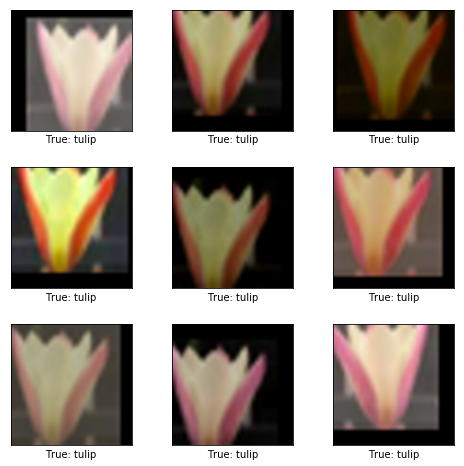

In [47]:
plot_distorted_image(img, cls)

## Perform optimization

* Batch size = 50
* num_images = 50,000
* 1,000 iterations == 1 Epoch

In [ ]:
if True:
# if False:
    optimize(num_iterations=1000000)

Learning start!. [2017-08-29 13:44:15]


## Results

In [ ]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=False)

### Convolutional Weights

In [ ]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

In [ ]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

### Output of convolutional layers

In [ ]:
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8, forward=True)
    plt.show()

In [ ]:
img, cls = get_test_image(16)
plot_image(img)

In [ ]:
plot_layer_output(output_conv1, image=img)

In [ ]:
plot_layer_output(output_conv2, image=img)

### Predicted class-labels

In [ ]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls], feed_dict={x: [img]})

In [ ]:
np.set_printoptions(precision=3, suppress=True)

print(label_pred[0])

In [ ]:
class_names[92]

In [ ]:
class_names[16]

## Close TensorFlow Session

In [ ]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Conclusion

This tutorial showed how to make a Convolutional Neural Network for classifying images in the CIFAR-10 data-set. The classification accuracy was about 79-80% on the test-set.

The output of the convolutional layers was also plotted, but it was difficult to see how the neural network recognizes and classifies the input images. Better visualization techniques are needed.